#### Problem 4

There is a claim that the *mtry* parameter in Random Forest plays a role of inexplicit regularization. Let's verify this claim by relicating the procedures by Mentch and Zhou in their arXiv preprints: https://arxiv.org/pdf/1911.00190.pdf, in particular the section 4. Since they did not enclose the randomness feeding into the regressors in the paper, different seeds are used for each test set that correspond to one training set per signal-to-noise ratio (SNR) $v$.

Firstly, the comparisons between baggings and random forests in terms of average difference in the test sets for 10 $v$ values for 2 models, the linear model and the MARS nonlinear model: \begin{align} Y_{\text{linear}} &= XB + E, \\
Y_{\text{MARS}} &= 10\sin(\pi X_1 X_2) + 20(X_3 - 0.05)^2 + 10X_4 + 5X_5 + E, \end{align} are made. Apart from the MSE differences, I also tried looking into the improvement brought by the forests in terms of the average MSE reduction (in $\%$) from simply bagging.

In [1]:
from sklearn.ensemble import (
    RandomForestRegressor as RFR, RandomForestClassifier as RFC,
    BaggingRegressor as BR, BaggingClassifier as BC)

from numpy import empty, zeros, ones, concatenate, geomspace as geoms, eye,\
    array, mean, std, argmin, set_printoptions, linspace as lins
from numpy.random import default_rng, normal, multivariate_normal
import time
from math import sqrt, sin, pi


set_printoptions(suppress=True)

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame as DF

In [2]:
rho_1 = 0.35

def get_cov_and_coeffs(sizes_dict):

    global rho_1
    
    # p = no. of features
    # s = no. of non-zeroing features
    # S_1 and B_1 should only depend on p and s
    p, s = sizes_dict['p'], sizes_dict['s']

    # S_1 is p * p covariance matrix
    S_1 = empty((p, p))
    for j in range(p):
        for i in range(p):
            S_1[i, j] = rho_1 ** abs(i - j)

    # B_1 is p * 1 coefficient matrix
    B_1 = concatenate((zeros((s, )), ones((p - s, ))))

    return S_1, B_1

In [3]:
# Setting of the linear model in https://arxiv.org/pdf/1911.00190.pdf

def get_lin_models(sizes_dict, S, B, v, i=0, train=True):

    global rho_1
    n, p = sizes_dict['n'], sizes_dict['p']
    # p. 11
    sigma_e = sqrt(B.transpose() @ S @ B / v)

    if train:

        rngx = default_rng(42)
        X_train = rngx.multivariate_normal(zeros((p,)), S, n)
        rnge = default_rng(69)
        E_train = rnge.normal(0, sigma_e, n)

        # create the train set using 42 & 69
        X_out, Y_out = X_train, X_train @ B + E_train

    else:

        rngx = default_rng(42 * (i + 1))
        X_test = rngx.multivariate_normal(zeros((p,)), S, n)
        rnge = default_rng(69 * (i + 1))
        E_test = rnge.normal(0, sigma_e, n)

        # create the train set using different random states
        X_out, Y_out = X_test, X_test @ B + E_test

    return X_out, Y_out

In [4]:
def get_nonlin_models(sizes_dict, v, i=0, train=True):

    global rho_1
    n, p = sizes_dict['n'], sizes_dict['p']
    # how find the sigma_e from v for the nonlinear model?
    # Y = 10 sin(π X_1 X_2) + 20(X_3 − 0.05)**2 + 10X_4 + 5X_5 + E
    # for convenience try var(Y) = 10**2 + 20**2 + 10**2 + 5**2 = 625
    sigma_e = 25 / sqrt(v)

    if train:

        rngx = default_rng(42)
        # sampled independently from Unif(0, 1)
        train_X = rngx.uniform(size=(n, p))
        rnge = default_rng(69)
        E_train = rnge.normal(0, sigma_e, n)
        X_train = train_X.transpose()
        
        Y_train = array([10 * sin(pi * x0 * x1) for (x0, x1) in zip(
            X_train[0], X_train[1])]) + array([20 * (
                x2 - 0.05) ** 2 for x2 in X_train[2]]) +\
                  array([10 * x3 for x3 in X_train[3]]) +\
                  array([5 * x4 for x4 in X_train[4]]) + E_train

        # create the train set using 42 & 69
        X_out, Y_out = train_X, Y_train

    else:

        rngx = default_rng(42 * (i + 1))
        # sampled independently from Unif(0, 1)
        test_X = rngx.uniform(size=(n, p))
        rnge = default_rng(69 * (i + 1))
        E_test = rnge.normal(0, sigma_e, n)
        X_test = test_X.transpose()

        Y_test = array([10 * sin(pi * x0 * x1) for (x0, x1) in zip(
            X_test[0], X_test[1])]) + array([20 * (
                x2 - 0.05) ** 2 for x2 in X_test[2]]) + \
                  array([10 * x3 for x3 in X_test[3]]) + \
                  array([5 * x4 for x4 in X_test[4]]) + E_test

        # create the test set using fixed random states
        X_out, Y_out = test_X, Y_test

    return X_out, Y_out

In [5]:
def workflow_q4a(vs, params_lin, params_msn):

    global test_repeats, test_n

    # should be done 1 time for each dataset setting
    S_in, B_in = get_cov_and_coeffs(params_lin)

    params_lin_test, params_msn_test = params_lin.copy(), params_msn.copy()
    params_lin_test['n'], params_msn_test['n'] = test_n, test_n

    results_lin, results_msn = [], []

    print("Sum of MSEs from {} test sets".format(test_repeats))
    print("""using Bagging & Random Forest respectively
with the linear model Y = XB + E first
and the MARS nonlinear model in section 4.1 next:
SNR     sum(MSE(Bag))   sum(MSE(RF))  mean(diff) mean(diff, %)
==============================================================""")

    for v in vs:
        
        X_train_lin, train_Y_lin = get_lin_models(params_lin, S_in, B_in, v)
        X_train_msn, train_Y_msn = get_nonlin_models(params_msn, v)
        Y_train_lin, Y_train_msn = train_Y_lin.ravel(), train_Y_msn.ravel()
        brmses_lin, rfrmses_lin, brmses_msn, rfrmses_msn = 0, 0, 0, 0
        
        for j in range(1, test_repeats + 1):
            
            # for the linear model Y = XB + E
            X_test_lin, test_Y_lin = get_lin_models(
                params_lin_test, S_in, B_in, v, j, train=False)
            Y_test_lin = test_Y_lin.ravel()
            # fit using bagging (the regressor one)
            Y_br_lin = BR(random_state=(777 * j)).fit(
                X_train_lin, Y_train_lin).predict(X_test_lin)
            # fit using the random forest with only 1 / 3 features fed in
            # 1 / 3 c.f. the default value in the R packages
            Y_rfr_lin = RFR(random_state=(3000 * j), max_features=(
                    1 / 3)).fit(X_train_lin, Y_train_lin).predict(X_test_lin)
            brmses_lin += sum((Y_br_lin - Y_test_lin) ** 2) / test_n
            rfrmses_lin += sum((Y_rfr_lin - Y_test_lin) ** 2) / test_n

            # for MARS nonlinear model
            X_test_msn, test_Y_msn = get_nonlin_models(
                params_msn_test, v, j, train=False)
            Y_test_msn = test_Y_msn.ravel()
            # fit using bagging (the regressor one)
            Y_br_msn = BR(random_state=(777 * j)).fit(
                X_train_msn, Y_train_msn).predict(X_test_msn)
            # fit using the random forest with only 1 / 3 features fed in
            # 1 / 3 c.f. the default value in the R packages
            Y_rfr_msn = RFR(random_state=(3000 * j), max_features=(
                    1 / 3)).fit(X_train_msn, Y_train_msn).predict(X_test_msn)
            brmses_msn += sum((Y_br_msn - Y_test_msn) ** 2) / test_n
            rfrmses_msn += sum((Y_rfr_msn - Y_test_msn) ** 2) / test_n

        result_lin = (brmses_lin - rfrmses_lin) / test_repeats
        per_lin = 100 * result_lin * test_repeats / brmses_lin
        print("{:.4f} {:14.4f} {:14.4f} {:11.4f} {:13.4f}".format(
            v, brmses_lin, rfrmses_lin, result_lin, per_lin))
        results_lin.append(result_lin)
        
        result_msn = (brmses_msn - rfrmses_msn) / test_repeats
        per_msn = 100 * result_msn * test_repeats / brmses_msn
        print("{:.4f} {:14.4f} {:14.4f} {:11.4f} {:13.4f}".format(
            v, brmses_msn, rfrmses_msn, result_msn, per_msn))
        results_msn.append(result_msn)
    
    # for convenience
    print("""Then the MSE differences from bagging and random forests
based on 10 different values of SNR ratio from the linear model are""")
    print(results_lin)
    print("While the same quantities from the MARS nonlinear model are")
    print(results_msn)

    return results_lin, results_msn

In [6]:
def workflow_q4b(ms, vs, params_lin, params_msn):

    global test_repeats

    # should be done 1 time for each dataset setting
    S_in, B_in = get_cov_and_coeffs(params_lin)

    params_lin_test, params_msn_test = params_lin.copy(), params_msn.copy()
    test_n = params_lin_test['n']

    al_lin, means_lin, stds_lin, mins_mse_lin, argmins_lin = [], [], [], [], []
    al_msn, means_msn, stds_msn, mins_mse_msn, argmins_msn = [], [], [], [], []

    print("Summary from {} test sets".format(test_repeats))
    print("""using Random Forest with different SNR and mtry values
with the linear model Y = XB + E first
and the MARS nonlinear model in section 4.1 next:
SNR    mean(mtry) SD(mtry)    min(MSE) argmin(MSE)
==================================================""")

    for v in vs:

        X_train_lin, train_Y_lin = get_lin_models(params_lin, S_in, B_in, v)
        X_train_msn, train_Y_msn = get_nonlin_models(params_msn, v)
        Y_train_lin, Y_train_msn = train_Y_lin.ravel(), train_Y_msn.ravel()
        rfrmses_lin, rfrmses_msn = [], []
        rfr_ms_lin, rfr_ms_msn = [], []

        for j in range(1, test_repeats + 1):

            this_lin, this_msn = [], []

            # for the linear model Y = XB + E
            X_test_lin, test_Y_lin = get_lin_models(
                params_lin_test, S_in, B_in, v, j, train=False)
            Y_test_lin = test_Y_lin.ravel()

            # for MARS nonlinear model
            X_test_msn, test_Y_msn = get_nonlin_models(
                params_msn_test, v, j, train=False)
            Y_test_msn = test_Y_msn.ravel()

            for m in ms:

                # linear model
                # fit using the random forest with only 1 / 3 features fed in
                # 1 / 3 c.f. the default value in the R packages
                Y_rfr_lin = RFR(random_state=(3000 * j), max_features=m).fit(
                    X_train_lin, Y_train_lin).predict(X_test_lin)
                this_lin.append(sum((Y_rfr_lin - Y_test_lin) ** 2) / test_n)

                # MARS nonlinear model
                # fit using the random forest with only 1 / 3 features fed in
                # 1 / 3 c.f. the default value in the R packages
                Y_rfrmses_msn = RFR(random_state=(3000 * j), max_features=m).fit(
                    X_train_msn, Y_train_msn).predict(X_test_msn)
                this_msn.append(sum((Y_rfrmses_msn - Y_test_msn) ** 2) / test_n)

            # change the lists to numpy arrays
            this_lin, this_msn = array(this_lin), array(this_msn)
            # then find the indices of the argmin with respect to m
            # e.g. min_ind_lin = argmin_(ind of m) (this_lin)
            min_ind_lin, min_ind_msn = argmin(this_lin), argmin(this_msn)
            min_lin, min_msn = min(this_lin), min(this_msn)
            # append the corresponding minimized MSEs and m values
            [x.append(y) for (x, y) in zip(
                [rfrmses_lin, rfrmses_msn, rfr_ms_lin, rfr_ms_msn],
                [min_lin, min_msn, ms[min_ind_lin], ms[min_ind_msn]])]

        # should give the mean and sample SD of the linear model
        # for each of the test_n test sets
        mean_lin, std_lin = mean(rfr_ms_lin), std(rfr_ms_lin, ddof=1)
        min_mse_lin, argmin_lin = min(
            rfrmses_lin), rfr_ms_lin[argmin(rfrmses_lin)]
        print("{:.4f} {:10.4f} {:8.4f} {:11.4f} {:11.2f}".format(
            v, mean_lin, std_lin, min_mse_lin, argmin_lin))
        [x.append(y) for (x, y) in zip(
            [al_lin, means_lin, stds_lin, mins_mse_lin, argmins_lin],
            [rfr_ms_lin, mean_lin, std_lin, min_mse_lin, argmin_lin])]

        # should give the mean and sample SD of the MARS nonlinear model
        # for each of the test_n test sets
        mean_msn, std_msn = mean(rfr_ms_msn), std(rfr_ms_msn, ddof=1)
        min_mse_msn, argmin_msn = min(
            rfrmses_msn), rfr_ms_msn[argmin(rfrmses_msn)]
        print("{:.4f} {:10.4f} {:8.4f} {:11.4f} {:11.2f}".format(
            v, mean_msn, std_msn, min_mse_msn, argmin_msn))
        [x.append(y) for (x, y) in zip(
            [al_msn, means_msn, stds_msn, mins_mse_msn, argmins_msn],
            [rfr_ms_msn, mean_msn, std_msn, min_mse_msn, argmin_msn])]

    # for convenience
    print("""Then the mean, sample SD for the optimal mtry values (n = {}),
and the smallest MSE value and the corresponding optimal mtry value
out of {} test sets are""".format(test_repeats, test_repeats))
    print([[round(n, 4) for n in thelist] for thelist in means_lin],
          stds_lin, mins_mse_lin,
          [[round(n, 4) for n in thelist] for thelist in argmins_lin])
    print("The distribution (n = {}) of the mtry values is".format(test_repeats))
    print([[round(n, 2) for n in thelist] for thelist in al_lin])
    print("While the same quantities from the MARS nonlinear model are")
    print([[round(n, 4) for n in thelist] for thelist in means_msn],
          stds_msn, mins_mse_msn,
         [[round(n, 4) for n in thelist] for thelist in argmins_msn])
    print("And the mtry values distribution (n = {}) is".format(test_repeats))
    print([[round(n, 2) for n in thelist] for thelist in al_msn])

    # expected results_lin:
    # list of 10 lists [per v]
    # of 500 values [per test set]
    # of argmin(MSE on each test set) [choices from 0.05 to 1]
    results_lin = [al_lin, means_lin, stds_lin, mins_mse_lin, argmins_lin]
    results_msn = [al_msn, means_msn, stds_msn, mins_mse_msn, argmins_msn]

    return results_lin, results_msn

In [7]:
# Setting of the linear model in https://arxiv.org/pdf/1911.00190.pdf

# Part A
# The linear Y = XB + E (and the MARS linear model (called marsa))
# Low: n = 100, p = 10, s = 5
low = {'n': 100,        'p': 10,    's': 5}
# Medium: n = 500, p = 100, s = 5
medium = {'n': 500,     'p': 100,   's': 5}
# High-10: n = 100, p = 1000, s = 10
high_10 = {'n': 100,    'p': 1000,  's': 10}

# The MARS nonlinear model
low_marsb = {'n': 200,  'p': 5, 's': 5}
med_marsb = {'n': 500,  'p': 5, 's': 5}
hig_marsb = {'n': 1000, 'p': 5, 's': 5}

# Part B
# The linear Y = XB + E (and the MARS linear model (called marsa))
# p = 20, s = 10
# small: n = 50, large: n = 500
smo_lin = {'n': 50,     'p': 20, 's': 10}
lar_lin = {'n': 500,    'p': 20, 's': 10}

# The MARS nonlinear model: p = 5, s = 5
smo_marsb = {'n': 50,   'p': 5, 's': 5}
lar_marsb = med_marsb.copy()

# Section 4 how to create the test set
# the test_n here only for part A
# Part B use the same n as the training sets
test_n, test_repeats = 1000, 500
v_list = geoms(0.05, 6.0, 10)

# For part B, mtry ranges from 0.05 to 1
mtry_list = lins(0.05, 1, 20)

In [8]:
start = time.perf_counter()

# Workflow, part A
lin_low, msn_low = workflow_q4a(v_list, low, low_marsb)
lin_med, msn_med = workflow_q4a(v_list, medium, med_marsb)
lin_h10, msn_h10 = workflow_q4a(v_list, high_10, hig_marsb)

# Workflow, part B
lin_smo, msn_smo = workflow_q4b(mtry_list, v_list, smo_lin, smo_marsb)
lin_lar, msn_lar = workflow_q4b(mtry_list, v_list, lar_lin, lar_marsb)

# take out the info from the workflow of part B
lin_smo_dist, msn_smo_dist = lin_smo[0], msn_smo[0]
lin_lar_dist, msn_lar_dist = lin_lar[0], msn_lar[0]
ml_min_smo, mm_min_smo = lin_smo[-1], msn_smo[-1]
ml_min_lar, mm_min_lar = lin_lar[-1], msn_lar[-1]

# flatten the distributions which are lists of lists (on the same SNR values)
dist_lin_smo = [item for sublist in lin_smo_dist for item in sublist]
dist_msn_smo = [item for sublist in msn_smo_dist for item in sublist]
dist_lin_lar = [item for sublist in lin_lar_dist for item in sublist]
dist_msn_lar = [item for sublist in msn_lar_dist for item in sublist]

Sum of MSEs from 500 test sets
using Bagging & Random Forest respectively
with the linear model Y = XB + E first
and the MARS nonlinear model in section 4.1 next:
SNR     sum(MSE(Bag))   sum(MSE(RF))  mean(diff) mean(diff, %)
0.0500    101231.9643     92369.6019     17.7247        8.7545
0.0500   7421090.3576   6677340.5100   1487.4997       10.0221
0.0851     59495.4515     54437.0270     10.1168        8.5022
0.0851   4359845.7985   3924517.7806    870.6560        9.9849
0.1449     35174.9902     32215.9845      5.9180        8.4122
0.1449   2558849.3349   2306499.5966    504.6995        9.8618
0.2466     20905.9473     19169.1711      3.4736        8.3076
0.2466   1502815.1181   1356287.1863    293.0559        9.7502
0.4198     12549.7825     11524.9637      2.0496        8.1660
0.4198    881119.3275    798059.8784    166.1189        9.4266
0.7146      7693.6612      7044.9958      1.2973        8.4312
0.7146    517243.7647    469888.0089     94.7115        9.1554
1.2164      4838.0

0.0500     0.1660   0.1774    317.9827        0.20
0.0500     0.1379   0.2066  10500.8574        0.05
0.0851     0.1934   0.1849    186.2949        0.15
0.0851     0.1409   0.2087   6170.1003        0.45
0.1449     0.2401   0.1965    111.2859        0.45
0.1449     0.1409   0.2068   3652.8425        0.45
0.2466     0.2883   0.1875     65.3666        0.20
0.2466     0.1546   0.2126   2123.2164        0.05
0.4198     0.3505   0.2005     39.8132        0.20
0.4198     0.1733   0.2448   1237.6510        0.05
0.7146     0.4256   0.2022     24.3951        0.45
0.7146     0.1871   0.2442    733.8564        0.85
1.2164     0.5008   0.2009     15.5323        0.65
1.2164     0.1996   0.2557    436.5570        0.05
2.0707     0.5622   0.2033     10.1288        0.95
2.0707     0.1992   0.2405    253.7960        0.05
3.5248     0.6021   0.1901      7.2860        0.45
3.5248     0.2537   0.2653    151.9641        0.05
6.0000     0.6686   0.1789      5.4391        0.45
6.0000     0.3264   0.2561     

It can be seen that the percentage of the average MSE reduction brought by the forests from bagging is quite stable, ranging between $6.39\%$ to $10.02\%$. In particular,
- For the low dimension setting, the percentage reduction given by the linear model drops then goes up even higher to $9.25\%$ as the $v$ value increases, while the figure by the MARS model drops all the way.
- For the medium dimension setting, the precentage reduction given by the linear model increases from $8.05\%$ to $9.06\%$, while the figure by the MARS model drops from $9.55\%$ to $8.93\%$.
- For the high dimension (*high-10*) setting, the precentage reudction given by the linear model drops from $7.78\%$ to $6.39\%$, while the figure by the MARS model fluctuates between $9.37\%$ and $9.76\%$.

Anyway, the differences already show the *mtry* parameter in the forests -- set to 1/3 of all the features from the training set when fitting to be in line with the setting in the *R* packages, while the same parameter in bagging stays at 1 -- did improve the fitting with lower MSE to the test sets on average. It is also showed that for the linear model, different settings provide vastly different MSE difference (which is probably related to the training sample size, e.g. the medium setting gives around 20 times the MSE differences the low setting does). This might be a reason that the authors only include the medium setting (in orange) in the paper.

In [9]:
# the indices for plotting the graphs
inds = lins(1, len(v_list), len(v_list))
v_strings = [round(v, 2) for v in v_list]
inds_corr = [x - 1 for x in inds]
rights = [x - 0.85 for x in inds]
lefts = [x - 1.15 for x in inds]

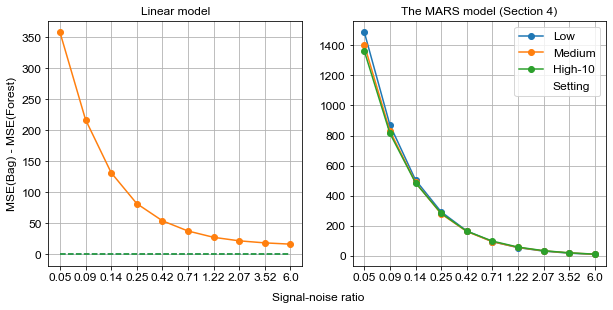

In [12]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

figa, [axea, axeb] = plt.subplots(figsize=(10, 4.5), ncols=2)

#axea.plot(inds, lin_low, 'o-', label="Low")
axea.plot(inds, [0] * len(inds), '--', label="Low")
axea.plot(inds, lin_med, 'o-', label="Medium")
axea.plot(inds, [0] * len(inds), '--', label="High-10")
#axea.plot(inds, lin_h10, 'o-', label="High-10")
axeb.plot(inds, msn_low, 'o-', label="Low")
axeb.plot(inds, msn_med, 'o-', label="Medium")
axeb.plot(inds, msn_h10, 'o-', label="High-10")
plt.setp([axea, axeb], xticks=inds, xticklabels=v_strings)

for ax in [axea, axeb]:
    # Create empty plot with blank marker containing the extra label
    ax.plot([], [], ' ', label="Setting")
    ax.grid()

# put the labels, titles and legends if necessary

axea.set_ylabel('MSE(Bag) - MSE(Forest)')
axea.set_title("Linear model", fontsize=12)
axeb.set_title("The MARS model (Section 4)", fontsize=12)
figa.supxlabel("Signal-noise ratio", fontsize=12)
axeb.legend()

As for the graphs, they look quite different compared to the original ones. It could be because the randomness as the test sets are created is different, but the general trend observed by Mentch and Zhou is still present. On average, the difference bewteen the MSE by bagging and from random forests is decreasing as the signal-noise ratio $v$ is increasing. It is a bit different that the MSE on the test sets by bagging is higher than from random forests in *all the settings* for all the $v$ values available, and the difference is a lot more obvious than what Mentch and Zhou provided.

However to play safe, I still want to find the so-called "optimal" *mtry* parameter for the random forests under each SNR value $v$. After trying on *500* different test sets for each training set, the following plots not only show the mean $\pm$ 1 SD of the distribution of the optimal *mtry* value for each $v$, but also show which *mtry* value gives the lowest MSE from all the test sets, denoted with the dots of the same colors.

C:\Users\yukif\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
C:\Users\yukif\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
C:\Users\yukif\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of th

This part takes 99992.80 seconds!


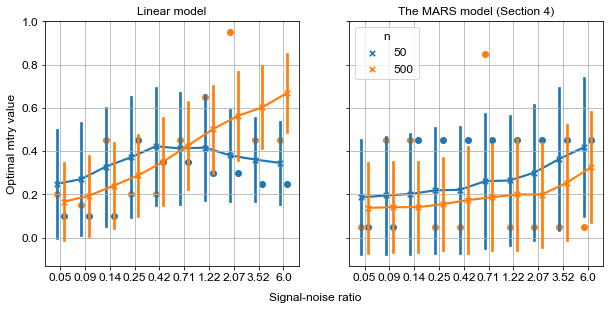

In [11]:
figc, [axec, axed] = plt.subplots(figsize=(10, 4.5), ncols=2, sharey=True)

# long lists consisting the distributions of the optimal mtry values
# on all the SNR (v) values for the linear model and the MARS nonlinear
# model in Section 4 flatten for plotting using seaborn function calls

# put everything you need within the DataFrames
dict_lin = {"v": [y for x in v_list for y in (x,)*(test_repeats)] * 2,
            "y": dist_lin_smo + dist_lin_lar,
            "n": ['50'] * (len(v_list) * test_repeats) +
                 ['500'] * (len(v_list) * test_repeats)}
df_lin = DF(dict_lin)

dict_msn = {"v": [y for x in v_list for y in (x,)*(test_repeats)] * 2,
            "y": dist_msn_smo + dist_msn_lar,
            "n": ['50'] * (len(v_list) * test_repeats) +
                 ['500'] * (len(v_list) * test_repeats)}
df_msn = DF(dict_msn)

# Plot Mean +/- 1SD
# Plot the optimal mtry values against v values for Y = XB + E
sns.pointplot(x="v", y="y", hue="n", data=df_lin, dodge=0.3, ax=axec,
              ci="sd", markers="x", scale=0.8).set(xlabel=None)
# Close the legend in axec
axec.legend([], [], frameon=False)
# Plot the optimal mtry values against v values for MARS nonlinear model
sns.pointplot(x="v", y="y", hue="n", data=df_msn, dodge=0.3, ax=axed,
              ci="sd", markers="x", scale=0.8).set(xlabel=None, ylabel=None)

# Also plot the optimal mtry value for each v values
# where the smallest test set MSE is obtained
axec.scatter(rights, ml_min_smo, label="n = 50")
axec.scatter(lefts, ml_min_lar, label="n = 500")
axed.scatter(rights, mm_min_smo, label="n = 50")
axed.scatter(lefts, mm_min_lar, label="n = 500")

plt.setp([axec, axed], xticks=inds_corr, xticklabels=v_strings)

for ax in [axec, axed]:
    ax.grid()
    
# put the labels, titles and legends if necessary
    
axec.set_ylabel('Optimal mtry value')
axec.set_title("Linear model", fontsize=12)
axed.set_title("The MARS model (Section 4)", fontsize=12)
figc.supxlabel("Signal-noise ratio", fontsize=12)

end = time.perf_counter()
print("This part takes {:.2f} seconds!".format(end - start))

# plt.show()

Although the *mtry* value (see the dots in the plots) that gives the smallest MSE from all the testing sets vary a lot compared to Fig. 5 of the original paper -- possibly because the randomness used here and there might be quite different, it's still arguable that the distribution results still follow the trend in Fig. 10 of the original paper, that
- for the linear model, the optimal *mtry* value of the larger training set $(n = 500)$ on average of 500 test sets (also $n = 500$) per signal-noise ratio $v$ is increasing along $v$, and the quantity on average surpasses that of the smaller training set $(n = 50)$ at a slightly (?) larger $v$ values ($0.7147$);
- for the MARS nonlinear model, on average, the optimal *mtry* value is still higher for the smallest training set for all the $v$ values.

The trends displayed in these figures, along with the numbers showed previously, show that fitting the *mtry* parameter in the random forests by minimizing the test set MSE usually give the values away from 1. This again implies we can (implicitly) regularize the forests by varying the *mtry* parameter. $\Box$

Given $z_i|\mu_i \sim N(\mu_i, 1)$ and $\mu_i \sim N\left(0, \sigma^2\right)$, then the posterior of $\mu_i$ given $z_i$ should be
\begin{equation}
    \begin{split}
        \mu_i | z_i &\sim N\left(\dfrac{\sigma^2 z_i}{1 + \sigma^2}, \dfrac{\sigma^2}{1 + \sigma^2}\right) \Rightarrow E(\mu_i | z_i, \sigma^2) = \dfrac{\sigma^2 z_i}{1 + \sigma^2}, \text{Var}(\mu_i | z_i, \sigma^2) = \dfrac{\sigma^2}{1 + \sigma^2} \\
        \Rightarrow E((\mu_i)^2 | z_i, \sigma^2) &= \text{Var}(\mu_i | z_i, \sigma^2) + \left[E(\mu_i | z_i, \sigma^2)\right]^2 = \dfrac{\sigma^2}{1 + \sigma^2} + \dfrac{(\sigma^2)^2 (z_i)^2}{(1 + \sigma^2)^2};
    \end{split}
\end{equation}
Meanwhile, 
\begin{equation}
    \begin{split}
        p(Z, M | \sigma^2) &= p(Z | M, \sigma^2) p(M | \sigma^2) = \prod_i p(z_i | \mu_i, \sigma^2) p(\mu_i | \sigma^2) \\
        &= \prod_i \dfrac{\exp(-(z_i - \mu_i)^2/(2 \cdot 1^2))}{\sqrt{2\pi}} \cdot \dfrac{\exp(-(\mu_i)^2/(2\sigma^2))}{\sqrt{2\pi\sigma^2}} \\
        \Rightarrow \ln p(Z, M | \sigma^2) &= \sum_i (-(z_i - \mu_i)^2 / 2 - (\mu_i)^2 / (2\sigma^2)) - \ln (2\pi \sigma);
    \end{split}
\end{equation}
So in the M-step we should maximize $Q(\sigma^2, (\sigma_{\text{old}})^2)$
\begin{equation}
    \begin{split}
         &= E_{M | Z, (\sigma_{\text{old}})^2} (\ln p(Z, M | \sigma^{2})) = E_{M | Z, (\sigma_{\text{old}})^2} \left(\sum_i \ln p(z_i, \mu_i | \sigma^{2})\right) \\
        &= \sum_i E_{\mu_i | z_i, (\sigma_{\text{old}})^2} \left(-\dfrac{(z_i - \mu_i)^2}{2} - \dfrac{(\mu_i)^2}{2\sigma^2} - \ln (2\pi) - \dfrac{\ln \sigma^2}{2}\right) \\
        &= -\dfrac{1}{2} \sum_i E_{\mu_i | z_i, (\sigma_{\text{old}})^2} \left((z_i)^2 -2 z_i \mu_i + \left[1 + \dfrac{1}{\sigma^2}\right](\mu_i)^2 + 2 \ln (2\pi) + \ln \sigma^2\right) \\
        &= -N \ln (2\pi) - \dfrac{N \ln \sigma^2}{2} - \dfrac{1}{2} \sum_i (z_i)^2 + \sum_i z_i E(\mu_i | z_i, (\sigma_{\text{old}})^2) - \dfrac{1}{2}\dfrac{\sigma^2 + 1}{\sigma^2} \sum_i E((\mu_i)^2 | z_i, (\sigma_{\text{old}})^2) \\
        &= -N \ln (2\pi) - \dfrac{N \ln \sigma^2}{2} - \dfrac{1}{2} \sum_i (z_i)^2 + \dfrac{(\sigma_{\text{old}})^2}{1 + (\sigma_{\text{old}})^2} \sum_i (z_i)^2 - \dfrac{\sigma^2 + 1}{2\sigma^2} \sum_i \left[\dfrac{(\sigma_{\text{old}})^2}{1 + (\sigma_{\text{old}})^2} + \dfrac{(\sigma_{\text{old}})^4 (z_i)^2}{(1 + (\sigma_{\text{old}})^2)^2}\right]
    \end{split}
\end{equation} in particular with respect to $\sigma^2$:
\begin{equation}
    \begin{split}
        \dfrac{\partial Q}{\partial \sigma^2} &= -\dfrac{N}{2 \sigma^2} + \dfrac{1}{2\sigma^4} \sum_i \left[\dfrac{(\sigma_{\text{old}})^2}{1 + (\sigma_{\text{old}})^2} + \dfrac{(\sigma_{\text{old}})^4 (z_i)^2}{(1 + (\sigma_{\text{old}})^2)^2}\right] = 0 \\
        \Rightarrow \sigma^2 &= \sum_i \left[\dfrac{(\sigma_{\text{old}})^2}{1 + (\sigma_{\text{old}})^2} + \dfrac{(\sigma_{\text{old}})^4 (z_i)^2}{(1 + (\sigma_{\text{old}})^2)^2}\right] \div N.
    \end{split}
\end{equation}
Replacing $\sigma^2$ and $(\sigma_{\text{old}})^2$ with $1/\alpha$ and $1/\alpha_{\text{old}}$ should complete the M-step. Then once the log-likelihood from the marginal distribution for $Z$: 
\begin{equation}
    \begin{split}
    	z_i | \sigma^2 &\sim N(0, 1 + (\sigma_{\text{old}})^2) \\
        \Rightarrow p(Z | (\sigma_{\text{old}})^2) &= \prod_i p(z_i | (\sigma_{\text{old}})^2) = \prod_i \dfrac{\exp(-(z_i)^2 \div [2(1 + (\sigma_{\text{old}})^2)])}{\sqrt{2\pi (1 + (\sigma_{\text{old}})^2)}} \\
        \Rightarrow \ln p(Z | (\sigma_{\text{old}})^2 = 1/\alpha_{\text{old}}) &= -\sum_i \left[\dfrac{(z_i)^2}{1 + (\sigma_{\text{old}})^2} + \ln 2\pi (1 + (\sigma_{\text{old}})^2)\right]/2  
    \end{split}
\end{equation} is converged, we take $\hat{\alpha}$ = $\alpha_{\text{new}}$ and find $\hat{M} = Z/(1 + \hat{\alpha})$. $\Box$

Meanwhile we simply get $\hat{M_{JS}} = \left(1 - \dfrac{N-2}{(\lVert Z \rVert_2)^2}\right)Z$. So to verify the EM algorithm derived above, we set $\alpha = 1/4 \Rightarrow \sigma^2 = 4$, and $N = 10000$, and make the initial guess of $\sigma^2$ at $9$. Here are the results.

In [10]:
from numpy import where, empty, mean, log, pi, zeros, sqrt, exp, linspace
from numpy.random import default_rng, normal

# set up everything to get the M and Z
var = 4
a = var ** -1
# mu_i ~ N(0, sigma^2 = a^(-1)), so a here = 1/4
n = 10000
rngm = default_rng(42)
M = rngm.normal(0, sqrt(var), n)    # (mean, sd = 1/sqrt(2), sample size)
Z = empty(n, )
for m in M:
    m_in = where(M == m)[0][0]
    rngz = default_rng(69*(m_in + 1))
    Z[m_in, ] = rngz.normal(m, 1, 1)

Z_norm_sq = sum([z ** 2 for z in Z])
# guess sigma^2 = 1/(alpha) = 9 first, i.e. guess alpha = 1/9
var_old = 9
ilL_old = -Z_norm_sq / (2 * (1 + var_old)) - n * log(
    2 * pi * (1 + var_old)) / 2
var_list, ilL_list = [var_old], [ilL_old]

In [13]:
while True:

    # M-step
    b_old = var_old / (1 + var_old)
    var_new = b_old + b_old ** 2 * (Z_norm_sq / n)

    # after that get the new incomplete log likelihood
    ilL_new = -Z_norm_sq / (2 * (1 + var_new)) - n * log(
        1 + var_new) / 2 - n * log(2 * pi) / 2

    var_list.append(var_new)
    ilL_list.append(ilL_new)

    if ilL_new - ilL_old < 10 ** -12:
        var_est = var_new
        break

    # reassign the value to alpha
    var_old, ilL_old = var_new, ilL_new

In [14]:
# See the final EM-fitting result;
# when n = 10000, hat(a) should be close to the actual a
print("The estimated value of a is {}".format(1/var_est))

# eventually after the EM loop is completed
M_EM = Z * var_est / (1 + var_est)
M_MLE = Z.copy()
M_JS = (1 - (Z.shape[0] - 2)/(Z.transpose() @ Z)) * Z

# print the comparison
print("The SSE by EM is {}".format(
    sum([(p - t) ** 2 for (p, t) in zip(M, M_EM)])))
print("The SSE by MLE is {}".format(
    sum([(p - t) ** 2 for (p, t) in zip(M, M_MLE)])))
print("The SSE by JS is {}".format(
    sum([(p - t) ** 2 for (p, t) in zip(M, M_JS)])))

The estimated value of a is 0.2506587969533336
The SSE by EM is 7981.128327470119
The SSE by MLE is 9827.820178216154
The SSE by JS is 7981.096905134989


As expected, the JS gives smaller SSE than the MLE on $M = \{\mu_i\}$. The SSE given by EM is also close to James-Stein estimator. For readers' reference, here are also the plot of the incomplete log-likelihood on Z that monotonically increases before reaching the difference threshold, the plot of the value of $\alpha$ along the takes, and the density plot about $M$ with the distribution $N(0, 1/\hat{\alpha})$ that $M$ is estimated to be sampled from.

Text(0.5, 0, '$\\mu_i$')

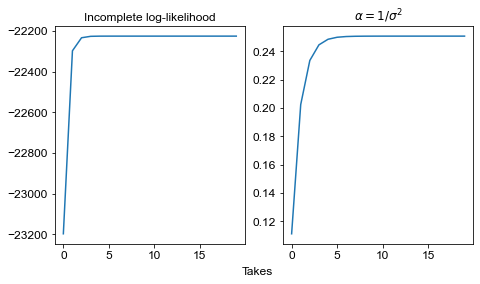

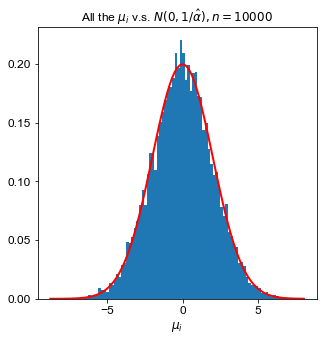

In [22]:
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# plot the incomplete log-likelihood, and the alpha
fige, [axee, axef] = plt.subplots(figsize=(7.5, 4), ncols=2, sharex=True)
axee.plot(ilL_list)
axee.set_title("Incomplete log-likelihood", fontsize=12)
axef.plot([1 / var for var in var_list])
axef.set_title(r"$\alpha = 1/\sigma^2$", fontsize=12)
repeats = linspace(0, len(var_list) - 1, len(var_list))
#plt.setp([axee], xticks=repeats,
#         xticklabels=[int(i+1) for i in repeats])
fige.supxlabel("Takes", fontsize=12)

# Plot all the (mu_i)s for reference
figg, axeg = plt.subplots(figsize=(5, 5))
count, bins, ignored = axeg.hist(M, 100, density=True)
axeg.plot(bins, 1/(sqrt(2 * pi * var_est)) * exp(
    -(bins)**2 / (2 * var_est)), linewidth=2, color='r')
axeg.set_title(("All the " + r"$\mu_i$ " +
                r"v.s. $N(0, 1/\hat \alpha), n = {}$".format(n)), fontsize=12)
axeg.set_xlabel(r"$\mu_i$")

#### Problem 3

The PXEM algorithm:

If $Y = \gamma X_1 B_1 + \gamma X_2 B_2 + E = \gamma X_3 B_3 + E$, where \begin{equation}
    \begin{split}
        B_1 &\sim N(0, (\sigma_1)^2 I_p), B_2 \sim N(0, (\sigma_2)^2 I_q) \text{ and } E \sim N(0, (\sigma_e)^2 I_{n}), \\
        \Rightarrow X_3 &= [X_1; X_2], B_3 = [B_1; B_2] \sim N(0, S_3), S_3 = \begin{bmatrix} (\sigma_1)^2 I_p & 0 \\ 0 & (\sigma_2)^2 I_q \end{bmatrix} \\ \Leftrightarrow T_3 &= (S_3)^{-1} = \begin{bmatrix} (\sigma_1)^{-2} I_p & 0 \\ 0 & (\sigma_2)^{-2} I_q \end{bmatrix},
    \end{split}
\end{equation} then the complete log-likelihood should be \begin{equation}
    \begin{split}
        \ln(Y, B_3 | S_3, (\sigma_e)^2) &= \ln (Y | B_3, (\sigma_e)^2) + \ln (B_3 | S_3) \\
        &= -\dfrac{n}{2} \ln (2\pi (\sigma_e)^2) -\dfrac{1}{2(\sigma_e)^2}\sum_{i=1}^n (Y_i - X_{3i} B_3)^2 \\
        &- \dfrac{(B_3)^T T_3 B_3}{2} - \dfrac{n}{2} \ln (2\pi (\sigma_1)^{2p} (\sigma_2)^{2q}) \\
        &= -\dfrac{n}{2} \ln (2\pi (\sigma_e)^2) -\dfrac{1}{2(\sigma_e)^2}\sum_{i=1}^n (Y_i - X_{3i} B_3)^2 \\
        &- \dfrac{(B_3)^T T_3 B_3}{2} - \dfrac{n}{2} \ln (2\pi) - \dfrac{np}{2} \ln(\sigma_1)^2 - \dfrac{nq}{2} \ln(\sigma_2)^2.
    \end{split}
\end{equation}

Taking the expectation of the (joint) distribution of $B_3$: \begin{equation}
    \begin{split}
        E_{B_3 | \cdots} (\ln(Y, B_3 | \cdots)) &= -\dfrac{n}{2} \ln (2\pi(\sigma_e)^2) - \dfrac{1}{2(\sigma_e)^2} \sum_{i = 1}^n E_{B_3 | \cdots} ((Y_i - \gamma X_{3i} B_3)^2) \\
        &- E_{B_3 | \cdots} \dfrac{(B_3)^T T_3 B_3}{2} - \dfrac{n}{2} \ln (2\pi) - \dfrac{np}{2} \ln(\sigma_1)^2 - \dfrac{nq}{2} ;
    \end{split}
\end{equation}

Since the posterior of $B_3$ is \begin{equation}
    \begin{split}
        p(B_3 | \cdots) &= N(M_4, S_4), \\
        \text{where } M_4 &= \left[(\sigma_e)^2 T_3  +  (X_3)^T X_3\right]^{-1} (X_3)^T Y, \quad S_4 = \left(T_3 + \dfrac{1}{(\sigma_e)^2} (X_3)^T X_3 \right)^{-1}.
    \end{split}
\end{equation} Then $E_{B_3, | \cdots} ((B_3)^T B_3) = (M_4)^T M_4 + \text{Tr}(S_4)$, and $E_{B_3 | \cdots} ((Y_i - \gamma X_{3i} B_3)^2)$ \begin{equation}
    \begin{split}
        &= (Y_i)^2 - 2 \gamma Y_i X_{3i} E_{B_3 | \cdots} (B_3) + \gamma^2 \text{Tr}\left[(X_{3i})^T X_{3i} (M_3 (M_3)^T + S_3)\right] \\
        &= (Y_i)^2 - 2 \gamma Y_i X_{3i} M_4 + \gamma^2 \text{Tr} \left[(X_{3i})^T X_{3i} (M_4 (M_4)^T + S_4)\right] \\
        &= (Y_i - \gamma X_{3i} M_4)^2 + \gamma^2 \text{Tr} \left[(X_{3i})^T X_{3i} S_4\right].
    \end{split}
\end{equation}Thus setting up the partial derivatives with respect to the parameters to complete the M-step: \begin{equation}
    \begin{split}
        \dfrac{\partial Q}{\partial \gamma^2} &= -\dfrac{p}{2(\gamma_1)^2} + \dfrac{(M_4)^T M_4 + \text{Tr}(S_1)}{2(\gamma_1)^4(\sigma_1)^2} = 0 \Rightarrow (\gamma_1)^2 = \dfrac{(M_1)^T M_1 + \text{Tr}(S_1)}{p(\sigma_1)^2}; \\
        \dfrac{\partial Q}{\partial (\sigma_1)^2} &= -\dfrac{p}{2(\sigma_1)^2} + \dfrac{(M_1)^T M_1 + \text{Tr}(S_1)}{2(\gamma_1)^2(\sigma_1)^4} = 0 \Rightarrow (\sigma_1)^2 = \dfrac{(M_1)^T M_1 + \text{Tr}(S_1)}{p(\gamma_1)^2}; \\
        \dfrac{\partial Q}{\partial (\sigma_2)^2} &= -\dfrac{q}{2(\sigma_2)^2} + \dfrac{(M_2)^T M_2 + \text{Tr}(S_2)}{2(\gamma_2)^2(\sigma_2)^4} = 0 \Rightarrow (\sigma_2)^2 = \dfrac{(M_2)^T M_2 + \text{Tr}(S_2)}{q(\gamma_2)^2}; \\
        \dfrac{\partial Q}{\partial (\sigma_e)^2} &= -\dfrac{n}{2(\sigma_e)^2} + \dfrac{(\lVert Y - \gamma X_3 M_4\rVert_2)^2 + (\gamma)^2\text{Tr}((X_3)^T X_3 S_4)}{2(\sigma_e)^4} = 0 \\
        \Rightarrow (\sigma_e)^2 &= [(\lVert Y - \gamma X_3 M_4\rVert_2)^2 + (\gamma)^2 \text{Tr}((X_3)^T X_3 S_4)]/n.
    \end{split}
\end{equation} Lastly to complete the R-step we just redefine $(\sigma_j)^2 := \gamma^2 (\sigma_j)^2, \quad j = 1, 2$.

The codes and the results of fitting the given data for this problem are as follows.

In [26]:
from numpy import array, where, empty, mean, log, pi, zeros, sqrt, eye, trace, loadtxt
from numpy.random import default_rng, normal
from numpy.linalg import pinv

# load and split the data as designed
datas = loadtxt("data_vc3.txt", skiprows=1)


Y = datas[:, 0]
X_3 = datas[:, 1:]
X_1 = X_3[:, :500]
X_2 = X_3[:, 500:]

n = Y.shape[0]
p = X_1.shape[1]
q = X_2.shape[1]

sig1_old, sig2_old, sige_old = 1, 1, 1

In [27]:
# the PXEM algorithm
def PXEM(Y, X_1, X_2, s1, s2, e, PX=True):

    global n, p, q
    
    lLs_st, lLs_px, inlLs_st, inlLs_px = [], [], [], []

    g1_old, g2_old = 1, 1
    sig1_old, sig2_old, sige_old = s1, s2, e

    while True:

        print("The existing parameters:")
        for values in [g1_old, g2_old, sig1_old, sig2_old, sige_old]:
            print(round(values, 6), end=" ")
        print("")

        # the Mean and SD related to the posterior of B_1, B_2
        M_1 = pinv((sige_old / sig1_old) ** 2 * eye(p) +
                   X_1.transpose() @ X_1) @ X_1.transpose() @ Y
        M_2 = pinv((sige_old / sig2_old) ** 2 * eye(q) +
                   X_2.transpose() @ X_2) @ X_2.transpose() @ Y
        S_1 = pinv(sig1_old ** -2 * eye(p) +
                   sige_old ** -2 * X_1.transpose() @ X_1)
        S_2 = pinv(sig2_old ** -2 * eye(q) +
                   sige_old ** -2 * X_2.transpose() @ X_2)

        B_1_exp = M_1.transpose() @ M_1 + trace(S_1)
        B_2_exp = M_2.transpose() @ M_2 + trace(S_2)

        # E step
        E_error_old = ((Y - g1_old * X_1 @ M_1
                         - g2_old * X_2 @ M_2).transpose() @ (
                                Y - g1_old * X_1 @ M_1 - g2_old * X_2 @ M_2) +
                        g1_old ** 2 * trace(X_1.transpose() @ X_1 @ S_1) +
                        g2_old ** 2 * trace(X_2.transpose() @ X_2 @ S_2))
        inc_ll_old = -(n * log(2 * pi * sige_old ** 2) +
                       E_error_old / sige_old ** 2) / 2
        ll_old = -(p * log(2 * pi * sig1_old ** 2) +
                   q * log(2 * pi * sig2_old ** 2) +
                   B_1_exp / (g1_old * sig1_old) ** 2 +
                   B_2_exp / (g2_old * sig2_old) ** 2) / 2 + inc_ll_old

        inlLs_st.append(inc_ll_old)
        lLs_st.append(ll_old)

        # M step
        if PX:
            g1_new = sqrt(B_1_exp / (p * sig1_old ** 2))
            g2_new = sqrt(B_2_exp / (q * sig2_old ** 2))
        else:
            g1_new, g2_new = g1_old, g2_old
        sig1_new = sqrt(B_1_exp / (p * g1_new ** 2))
        sig2_new = sqrt(B_2_exp / (q * g2_new ** 2))
        E_error_new = ((Y - g1_new * X_1 @ M_1
                        - g2_new * X_2 @ M_2).transpose() @ (
                Y - g1_new * X_1 @ M_1 - g2_new * X_2 @ M_2) +
        g1_new ** 2 * trace(X_1.transpose() @ X_1 @ S_1) +
        g2_new ** 2 * trace(X_2.transpose() @ X_2 @ S_2))
        sige_new = sqrt(E_error_new / n)

        inc_ll_new = -(n * log(2 * pi * sige_new ** 2) +
                       E_error_new / sige_new ** 2) / 2
        ll_new = -(p * log(2 * pi * sig1_new ** 2) +
                   q * log(2 * pi * sig2_new ** 2) +
                   B_1_exp / (g1_new * sig1_new) ** 2 +
                   B_2_exp / (g2_new * sig2_new) ** 2) / 2 + inc_ll_new

        if not lLs_px:
            lLs_px.append(ll_old)
            inlLs_px.append(inc_ll_old)
        inlLs_px.append(inc_ll_new)
        lLs_px.append(ll_new)

        if PX:
            print("The calculated parameters γ1, γ2:")
            print(g1_new, g2_new)

        print("Incomplete log-likelihood difference")
        if PX:
            print(inc_ll_new - inlLs_px[-2])
        else:
            print(inc_ll_new - inc_ll_old)
        print("Complete log-likelihood difference")
        if PX:
            print(ll_new - lLs_px[-2])
        else:
            print(ll_new - ll_old)

        if PX and abs(inc_ll_new - inlLs_px[-2]) < 10 ** -6:
            print("Incomplete log-likelihood looks converged!")
            break
        elif not PX and abs(inc_ll_new - inc_ll_old) < 10 ** -6:
            print("Incomplete log-likelihood looks converged!")
            break

        # R step
        sig1_old, sig2_old = sig1_new * g1_new, sig2_new * g2_new
        sige_old = sige_new

    if PX:
        print("PXEM done!")
        return lLs_st, inlLs_st
    else:
        print("Standard EM done!")
        return lLs_px, inlLs_px

In [28]:
lLs_std, inlLs_std = PXEM(Y, X_1, X_2, sig1_old, sig2_old, sige_old, PX=False)
lLs_PXed, inlLs_PXed = PXEM(Y, X_1, X_2, sig1_old, sig2_old, sige_old, PX=True)

The existing parameters:
1 1 1 1 1 
Incomplete log-likelihood difference
157.93686688260664
Complete log-likelihood difference
311.27990229240936
The existing parameters:
1 1 0.63745 0.637681 1.795362 
Incomplete log-likelihood difference
67.22535148815939
Complete log-likelihood difference
204.65399283206534
The existing parameters:
1 1 0.417597 0.417913 2.7028 
Incomplete log-likelihood difference
31.90098626381848
Complete log-likelihood difference
128.94698977272515
The existing parameters:
1 1 0.295035 0.295202 3.627228 
Incomplete log-likelihood difference
7.406325158135132
Complete log-likelihood difference
58.97749352801986
The existing parameters:
1 1 0.230822 0.230852 4.21132 
Incomplete log-likelihood difference
0.04147757585258205
Complete log-likelihood difference
27.642999970036612
The existing parameters:
1 1 0.193626 0.193592 4.260935 
Incomplete log-likelihood difference
1.4102515614595177
Complete log-likelihood difference
20.31236217755685
The existing parameters:
1 

The calculated parameters γ1, γ2:
0.7717394773788326 0.7716245099450845
Incomplete log-likelihood difference
-19.125287706722304
Complete log-likelihood difference
303.5866385201784
The existing parameters:
1 1 0.102988 0.103635 1.029802 
The calculated parameters γ1, γ2:
0.8171008609141198 0.8157579532317312
Incomplete log-likelihood difference
-13.710311664681115
Complete log-likelihood difference
245.47243024004848
The existing parameters:
1 1 0.084152 0.084541 1.077957 
The calculated parameters γ1, γ2:
0.8532925221591162 0.8515136506948694
Incomplete log-likelihood difference
-4.299932571897955
Complete log-likelihood difference
198.51523389422766
The existing parameters:
1 1 0.071806 0.071988 1.093519 
The calculated parameters γ1, γ2:
0.880116053207087 0.8783954688588285
Incomplete log-likelihood difference
3.963963899115356
Complete log-likelihood difference
163.6602661854131
The existing parameters:
1 1 0.063198 0.063234 1.079165 
The calculated parameters γ1, γ2:
0.9002068843

The calculated parameters γ1, γ2:
0.9998058214206768 0.9996775738033555
Incomplete log-likelihood difference
0.037168693436797184
Complete log-likelihood difference
0.34975246447447716
The existing parameters:
1 1 0.034661 0.033936 0.795913 
The calculated parameters γ1, γ2:
0.9998442314806831 0.9997287772250011
Incomplete log-likelihood difference
0.03071744199735349
Complete log-likelihood difference
0.289055252782191
The existing parameters:
1 1 0.034655 0.033927 0.795831 
The calculated parameters γ1, γ2:
0.999875465223599 0.9997715950765217
Incomplete log-likelihood difference
0.025392255724455026
Complete log-likelihood difference
0.23891236324516285
The existing parameters:
1 1 0.034651 0.033919 0.795764 
The calculated parameters γ1, γ2:
0.9999008258371301 0.9998074331516219
Incomplete log-likelihood difference
0.020994807679926453
Complete log-likelihood difference
0.19748157935737254
The existing parameters:
1 1 0.034647 0.033913 0.795708 
The calculated parameters γ1, γ2:
0.

The calculated parameters γ1, γ2:
1.0000011054925961 0.9999981128388516
Incomplete log-likelihood difference
6.247160843031452e-05
Complete log-likelihood difference
0.0005363548568766419
The existing parameters:
1 1 0.034637 0.033876 0.795442 
The calculated parameters γ1, γ2:
1.0000010141416062 0.9999983413229955
Incomplete log-likelihood difference
5.198814380946715e-05
Complete log-likelihood difference
0.00044282361591285735
The existing parameters:
1 1 0.034637 0.033876 0.795442 
The calculated parameters γ1, γ2:
1.0000009278639423 0.9999985408065958
Incomplete log-likelihood difference
4.328339883841181e-05
Complete log-likelihood difference
0.00036555204337673786
The existing parameters:
1 1 0.034637 0.033876 0.795442 
The calculated parameters γ1, γ2:
1.00000084693444 0.9999987151758262
Incomplete log-likelihood difference
3.605342152468438e-05
Complete log-likelihood difference
0.0003017188994363096
The existing parameters:
1 1 0.034637 0.033876 0.795442 
The calculated param

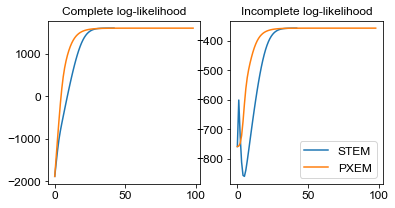

In [29]:
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

figa, [axea, axeb] = plt.subplots(figsize=(6, 3), ncols=2)
axea.plot(lLs_std, label="STEM")
axea.plot(lLs_PXed, label="PXEM")
axeb.plot(inlLs_std, label="STEM")
axeb.plot(inlLs_PXed, label="PXEM")
axea.set_title("Complete log-likelihood", fontsize=12)
axeb.set_title("Incomplete log-likelihood", fontsize=12)
plt.legend()

As we can observe from the graphs, the incomplete log-likelihood does increases all the way up till the difference falls within the $10^{-6}$ threshold.

#### Problem 2

hi_bye

Part (a): if in this part we define $A = \{\alpha_i\}, M = \{\mu_i\}, Y = \{y_i\}, k = 1$ to $K, i = 1$ to $N$, then since \begin{equation}
    \begin{split}
        p(y_i, M | A) &= p(y_i | M, A) p(M | A) \\
        &= \left(\dfrac{N!}{y_{i1}! y_{i2}! \cdots y_{ik}!} \prod_k (\mu_{ik})^{y_{ik}}\right) \cdot \dfrac{\Gamma\left(A = \sum_k \alpha_k\right)}{\Gamma(\alpha_1) \cdots \Gamma(\alpha_k)} \prod_k (\mu_{ik})^{\alpha_k - 1} \\
        &= C(N, A, y_i) \prod_k (\mu_{ik})^{y_{ik} + \alpha_k - 1}, \\
    \end{split}
\end{equation} Therefore the to complete the E-step, the $Q$ function is found as follows: \begin{equation}
    \begin{split}
        \Rightarrow Q(A, A_{\text{old}}) &= E_{M | Y, A_{\text{old}}} (\ln p(Y, M | A)) = E_{M | Y, A_{\text{old}}} \left(\sum_i \ln p(y_i, M | A)\right) \\
        &= E_{M | Y, A_{\text{old}}} \left(\sum_{i=1}^n \left(\ln C(N, A, y_i) + \sum_k (y_{ik} + \alpha_k - 1) \ln \mu_{ik}\right)\right) \\
        &= \sum_i \ln C(N, A, y_i) + \sum_i \sum_k (y_{ik} + \alpha_k - 1) E_{M | Y, A_{\text{old}}} (\ln \mu_{ik}); \\
        &= \sum_i \left[\ln (N!) + \ln \Gamma\left(\sum_k \alpha_k\right)\right] - \sum_i \sum_k \left[\ln \Gamma(\alpha_k) + \ln y_{ik}!\right] \\
        &+ \sum_i \sum_k (y_{ik} + \alpha_k - 1) \left[ \psi (y_{ik} + \alpha_{k, \text{old}}) - \psi \left(N + \sum_k \alpha_{k, \text{old}}\right)\right] \\
        &= \sum_k \sum_i \alpha_k \left[\psi(y_{ik} + \alpha_{k, \text{old}}) - \psi \left(N + \sum_k \alpha_{k, \text{old}}\right)\right] \\
        &- N \sum_k \ln \Gamma(\alpha_k) + N \ln \Gamma \left(\sum_k \alpha_k\right) + \Delta_{\text{old}}
    \end{split}
\end{equation} where $\Delta_{\text{old}}$ collects every terms independent of all $\alpha_k$. To complete the E-step we simply sub all $\alpha_k$ with their old values $\alpha_{k, \text{old}}$. As for the M-step, we try to maximize the $Q$ function from finding the extrema: \begin{equation} \begin{split}
    \Rightarrow \dfrac{\partial Q}{\partial \alpha_k} &= \sum_i \left[\psi (y_{ik} + \alpha_{k, \text{old}}) - \psi(N + \sum_k \alpha_{k, \text{old}})\right] + N\psi\left(\sum_k \alpha_k\right) - N\psi(\alpha_k); \\
    \dfrac{\partial^2 Q}{\partial \alpha_k \alpha_l} &= N\eta(\sum_k \alpha_k) - N\dfrac{\partial \psi(\alpha_k)}{\partial \alpha_l} = N\left(\eta\left(\sum_k \alpha_k\right) - \eta(\alpha_k) 1_{k = l?}\right), \end{split} \end{equation}
where $\psi(x) = \dfrac{d \ln \Gamma(x)}{dx}$, and $\eta(x) = \dfrac{d \psi(x)}{dx} = \dfrac{d^2 \ln \Gamma(x)}{dx^2}$. Since there are some implicit terms like $\sum_k \alpha_k$ within the digamma function $\psi(\cdot)$, we would rather try the numerical methods, like the Newton's method to update the $\alpha_k$: \begin{equation}
    \alpha_{k, \text{new}} = \alpha_{k, \text{old}} - \dfrac{\partial^2 Q}{\partial (\alpha_k)^2}\bigg|_{\alpha_k = \alpha_{k, \text{old}}} \times \dfrac{\partial Q}{\partial \alpha_k}\bigg|_{\alpha_k = \alpha_{k, \text{old}}}.
\end{equation} Finally, it might be easier to stop the loop once, for example, $|\alpha_{k, \text{new}} - \alpha_{k, \text{old}}| < 10^{-6}$ than evaluating the incomplete log-likelihood.

One big caveat about this numerical EM algorithm is the Q function is not concave (that $\ln \Gamma$ is convex), so the algorithm to update all $\alpha_k$ may not converge to their local (not to mention global) minima, including the MLE values.

Part (b): if different sample $y_i$ uses its own $A_i = \{\alpha_{ik}\}$ s.t. $A = \{A_i\}$, and $A_i = \exp(B^T x_i)$, which $B^T = [b_1, b_2, \cdots, b_K]^T$ then $\alpha_{ik} = (b_k)^T x_i \Leftrightarrow x_i = b_k \alpha_{ik}$, and \begin{equation}
    \begin{split}
	    \Rightarrow p(y_i, x_i, M| B) &=  p(y_i | M, B) p(x_i, M | B) \\
        &= \left(\dfrac{N!}{y_{i1}! y_{i2}! \cdots y_{ik}!} \prod_k (\mu_{ik})^{y_{ik}}\right) \cdot \dfrac{\Gamma\left(A_i = \sum_k (b_k)^T x_i\right)}{\Gamma((b_1)^T x_i) \cdots \Gamma((b_K)^T x_i)} \prod_k (\mu_{ik})^{(b_k)^T x_i - 1} \\
        &= \left(\dfrac{N!}{y_{i1}! y_{i2}! \cdots y_{ik}!} \dfrac{\Gamma\left(A_i = \sum_k (b_k)^T x_i\right)}{\Gamma((b_1)^T x_i) \cdots \Gamma((b_K)^T x_i)} \right) \prod_k (\mu_{ik})^{y_{ik} + (b_k)^T x_i - 1} \\
        \Rightarrow Q(B, B_{\text{old}}) &= E_{M | Y, X, B_{\text{old}}} \left(\sum_{i=1}^n \left(\ln C(N, A_i, y_i, x_i) + \sum_k (y_{ik} + (b_k)^T x_i - 1) \ln \mu_{ik}\right)\right) \\
        &= \sum_i \ln C(N, A_i, y_i, x_i) + \sum_i \sum_k (y_{ik} + (b_k)^T x_i - 1) E_{M | Y, X, B_{\text{old}}} (\ln \mu_{ik}); \\
        &= \sum_i \left[\ln (N!) + \ln \Gamma\left(\sum_k (b_k)^T x_i\right)\right] - \sum_i \sum_k \left[\ln \Gamma((b_k)^T x_i) + \ln y_{ik}!\right] \\
        &+ \sum_i \sum_k (y_{ik} + (b_k)^T x_i - 1) \left[ \psi (y_{ik} + (b_{k, \text{old}})^T x_i) - \psi \left(N + \sum_k (b_{k, \text{old}})^T x_i\right)\right] \\
        &= \sum_k \sum_i (b_k)^T x_i \left[\psi(y_{ik} + (b_{k, \text{old}})^T x_i) - \psi \left(N + \sum_k (b_{k, \text{old}})^T x_i\right)\right] \\
        &- \sum_i \sum_k \ln \Gamma((b_k)^T x_i) + \sum_i \ln \Gamma \left(\sum_k (b_k)^T x_i\right) + \Delta_{\text{old}}.
    \end{split}
\end{equation} To complete the E-step we sub all $b_k$ with their old values $b_{k, \text{old}}$ to evaluate the $Q$ function. As for the M-step, by denoting $b_k = [b_{k1}, b_{k2}, \cdots, b_{kp}]^T$, find \begin{equation} \begin{split}
    \dfrac{\partial Q}{\partial b_{km}} &= \sum_i x_{im} \left[\psi (y_{ik} + (b_{k, \text{old}})^T x_i) - \psi(N + \sum_k (b_{k, \text{old}})^T x_i)\right] \\
    &+ \sum_i \left[\psi\left(\sum_k (b_k)^T x_i\right) - \psi((b_k)^T x_i)\right] \cdot x_{im}; \\
    \dfrac{\partial^2 Q}{\partial b_{km} b_{kl}} &= \sum_i \left[\sum_i \eta\left(\sum_k (b_k)^T x_i\right) \cdot x_{il} - \dfrac{\partial \psi((b_k)^T x_i)}{\partial b_{kl}}\right] \cdot x_{im} \\
    &= \sum_i \left[\eta\left(\sum_k (b_k)^T x_i\right) - \eta((b_k)^T x_i)\right] x_{il} x_{im}. \end{split} \end{equation}
For the same reason, we would rather try the numerical methods, like the Newton's method to update the $b_{km}$: \begin{equation}
    b_{km, \text{new}} = b_{km, \text{old}} - \dfrac{\partial^2 Q}{\partial (b_{km})^2}\bigg|_{b_{km} = b_{km, \text{old}}} \times \dfrac{\partial Q}{\partial b_{km}}\bigg|_{b_{km} = b_{km, \text{old}}},
\end{equation} and stop the iteration regarding similar difference thresholds for $\alpha_k$ in last part.